<a href="https://colab.research.google.com/github/urwa-fatima/AdvanceMachineLearning_GNN/blob/main/GNN_AML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fsspec==2024.3.1

In [ ]:
!pip install --upgrade torch_geometric

In [ ]:
!pip install plotly

# Basic Implementation

In [ ]:
# Load dataset
dataset = TUDataset(root='PROTEINS', name='PROTEINS')

# Create DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
model = ClassicalIterativeGNN(num_node_features=dataset.num_node_features,
                              hidden_size=64,
                              num_classes=dataset.num_classes)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
print(f"Number of graphs: {len(dataset)}")
print(f"Number of node features: {dataset.num_node_features}")
print(f"Number of edge features: {dataset.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")

# Access the first graph in the dataset
data = dataset[0]

# Print the first graph's details
print("\nDetails of the first graph:")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node features: {data.x.shape}") # Node feature matrix shape
print(f"Edge features: {data.edge_attr.shape if data.edge_attr is not None else 'No edge features'}")
print(f"Graph label: {data.y}")

# You can also iterate over the first few graphs in the dataset
for i in range(5):
    print(f"\nGraph {i} details:")
    print(f"Graph {i} has {dataset[i].num_nodes} nodes and {dataset[i].num_edges} edges.")
    print(f"Node features shape: {dataset[i].x.shape}")
    print(f"Edge attributes shape: {dataset[i].edge_attr.shape if dataset[i].edge_attr is not None else 'No edge attributes'}")
    print(f"Label: {dataset[i].y}")

Number of graphs: 1113
Number of node features: 3
Number of edge features: 0
Number of classes: 2

Details of the first graph:
Number of nodes: 42
Number of edges: 162
Node features: torch.Size([42, 3])
Edge features: No edge features
Graph label: tensor([0])

Graph 0 details:
Graph 0 has 42 nodes and 162 edges.
Node features shape: torch.Size([42, 3])
Edge attributes shape: No edge attributes
Label: tensor([0])

Graph 1 details:
Graph 1 has 27 nodes and 92 edges.
Node features shape: torch.Size([27, 3])
Edge attributes shape: No edge attributes
Label: tensor([0])

Graph 2 details:
Graph 2 has 10 nodes and 34 edges.
Node features shape: torch.Size([10, 3])
Edge attributes shape: No edge attributes
Label: tensor([0])

Graph 3 details:
Graph 3 has 24 nodes and 92 edges.
Node features shape: torch.Size([24, 3])
Edge attributes shape: No edge attributes
Label: tensor([0])

Graph 4 details:
Graph 4 has 11 nodes and 42 edges.
Node features shape: torch.Size([11, 3])
Edge attributes shape: No

In [ ]:
# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [ ]:
# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)


In [ ]:
# Training loop
num_epochs = 100
criterion = nn.NLLLoss()

for epoch in range(num_epochs):
    loss = train(model, loader, optimizer, criterion)
    test_acc = evaluate(model, loader)
    print(f'Epoch: {epoch+1}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Final evaluation
final_acc = evaluate(model, loader)
print(f'Final Accuracy: {final_acc:.4f}')

Epoch: 1, Loss: 0.6756, Test Accuracy: 0.6424
Epoch: 2, Loss: 0.6338, Test Accuracy: 0.6640
Epoch: 3, Loss: 0.6867, Test Accuracy: 0.6415
Epoch: 4, Loss: 0.6761, Test Accuracy: 0.5957
Epoch: 5, Loss: 0.6748, Test Accuracy: 0.5957
Epoch: 6, Loss: 0.6728, Test Accuracy: 0.6424
Epoch: 7, Loss: 0.6622, Test Accuracy: 0.6541
Epoch: 8, Loss: 0.6523, Test Accuracy: 0.6649
Epoch: 9, Loss: 0.6445, Test Accuracy: 0.6631
Epoch: 10, Loss: 0.6483, Test Accuracy: 0.6685
Epoch: 11, Loss: 0.6308, Test Accuracy: 0.7071
Epoch: 12, Loss: 0.6318, Test Accuracy: 0.5957
Epoch: 13, Loss: 0.6540, Test Accuracy: 0.6667
Epoch: 14, Loss: 0.6443, Test Accuracy: 0.5957
Epoch: 15, Loss: 0.6380, Test Accuracy: 0.5921
Epoch: 16, Loss: 0.6483, Test Accuracy: 0.6586
Epoch: 17, Loss: 0.6356, Test Accuracy: 0.6748
Epoch: 18, Loss: 0.6342, Test Accuracy: 0.6703
Epoch: 19, Loss: 0.6301, Test Accuracy: 0.6694
Epoch: 20, Loss: 0.6449, Test Accuracy: 0.6649
Epoch: 21, Loss: 0.6329, Test Accuracy: 0.6631
Epoch: 22, Loss: 0.630

In [ ]:
class ClassicalIterativeGNN(nn.Module):
    def __init__(self, num_node_features, hidden_size, num_classes, num_iterations=5):
        super(ClassicalIterativeGNN, self).__init__()
        self.num_iterations = num_iterations


        # State update function
        self.state_update = nn.Sequential(
            nn.Linear(num_node_features + hidden_size, hidden_size),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Output function
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        num_nodes = x.size(0)

        # Initialize node states (h) with zeros, shape: (num_nodes, hidden_size)
        h = torch.zeros(num_nodes, self.state_update[0].out_features).to(x.device)

        # Iterative state update
        for _ in range(self.num_iterations):
            # Aggregate neighbor states
            neighbor_states = h[edge_index[1]]  # Neighbor states

            # If edge attributes are present, concatenate them with neighbor states
            if edge_attr is not None:
                edge_states = torch.cat([neighbor_states, edge_attr], dim=1)
            else:
                edge_states = neighbor_states  # If no edge features, only use neighbor states

            # Aggregate states from neighbors (message passing)
            aggregated = torch_geometric.utils.scatter(edge_states, edge_index[0], dim=0, dim_size=num_nodes, reduce='mean')

            # Update node states by concatenating original node features (x) with aggregated neighbor information and hidden state (h)
            node_inputs = torch.cat([x, aggregated], dim=1)  # Concatenate x (node features) and aggregated messages
            h = self.state_update(node_inputs)

        # Global mean pooling to get graph-level representation
        graph_embedding = torch_geometric.nn.global_mean_pool(h, batch)

        # Compute the output for classification
        out = self.output(graph_embedding)
        return F.log_softmax(out, dim=1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Hyper Parameter Experiments

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter
import json
import os

# Understanding the TUDataset - PROTEINS

In [ ]:
dataset = TUDataset(root='PROTEINS', name='PROTEINS')


In [48]:
# Overview of the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') # num_features and num_node_features is the same thing
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of edge feature: {data.num_edge_features}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of node features: 3
Number of edges: 162
Number of edge feature: 0
Average node degree: 3.86
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [59]:
# class distribution in our dataset
enzymes = 0
non_enzymes = 0

for data in dataset:
  if data.y.item() == 1:
    enzymes += 1
  else:
    non_enzymes += 1

print(f"Number of enzymes: {enzymes}")
print(f"Number of non-enzymes: {non_enzymes}")


Number of enzymes: 450
Number of non-enzymes: 663


In [54]:
# checking proteins with SSE of turns in proteins
indices = []
for i in range(len(dataset)):
  data = dataset[i]
  for j in range(data.x.shape[0]):
    if torch.all(data.x[j] == torch.tensor([0, 0, 1])):
      indices.append(i)
      break
print(len(indices))
print(indices)


88
[25, 36, 42, 123, 125, 168, 170, 232, 240, 305, 311, 313, 321, 343, 351, 353, 354, 410, 415, 419, 420, 424, 431, 433, 446, 453, 454, 507, 523, 537, 547, 554, 555, 563, 570, 581, 583, 587, 614, 615, 617, 621, 628, 639, 641, 642, 643, 653, 655, 656, 685, 727, 745, 750, 753, 755, 756, 765, 799, 831, 861, 885, 934, 936, 957, 969, 973, 980, 1018, 1029, 1030, 1041, 1050, 1057, 1061, 1063, 1066, 1072, 1074, 1076, 1080, 1085, 1089, 1092, 1098, 1109, 1110, 1112]


In [79]:
data = dataset[523]
data

Data(edge_index=[2, 72], x=[21, 3], y=[1])

In [80]:
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())

# Compute a fixed layout
pos = nx.spring_layout(G, seed=42)  # seed for reproducibility

node_colors = ['tab:red' if f[0] > 0 else 'tab:blue' if f[1] > 0 else 'orange' for f in data.x]
pred_node_colors = ['tab:green' if p > 0 else 'tab:gray' for p in data.y]


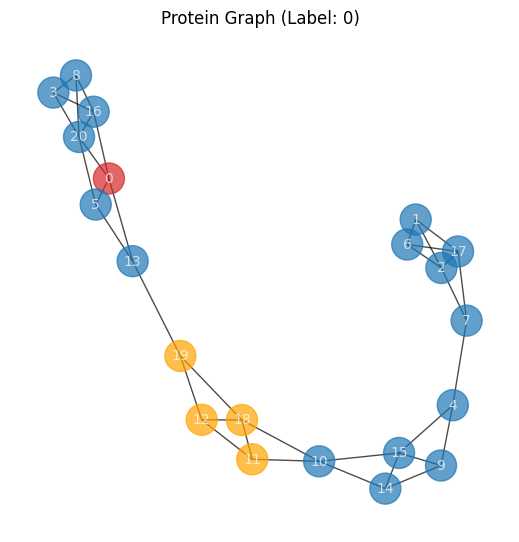

In [84]:
# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw(G, pos=pos, node_color=node_colors, with_labels=True, node_size=500, font_size=10, font_color="white", alpha=0.7,)
plt.title(f"Protein Graph (Label: {data.y.item()})")
plt.show()

Message Passing and Pooling Layers of GNN

In [ ]:
class ClassicalIterativeGNN(nn.Module):
    def __init__(self, num_node_features, hidden_size, num_classes, num_iterations=5):
        super(ClassicalIterativeGNN, self).__init__()
        self.num_iterations = num_iterations


        # State update function
        self.state_update = nn.Sequential(
            nn.Linear(num_node_features + hidden_size, hidden_size),  # Adjusted input size
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

        # Output function
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        num_nodes = x.size(0)

        # Initialize node states (h) with zeros, shape: (num_nodes, hidden_size)
        h = torch.zeros(num_nodes, self.state_update[0].out_features).to(x.device)

        # Iterative state update
        for _ in range(self.num_iterations):
            # Aggregate neighbor states
            neighbor_states = h[edge_index[1]]  # Neighbor states

            # If edge attributes are present, concatenate them with neighbor states
            if edge_attr is not None:
                edge_states = torch.cat([neighbor_states, edge_attr], dim=1)
            else:
                edge_states = neighbor_states  # If no edge features, only use neighbor states

            # Aggregate states from neighbors (message passing)
            aggregated = torch_geometric.utils.scatter(edge_states, edge_index[0], dim=0, dim_size=num_nodes, reduce='mean')

            # Update node states by concatenating original node features (x) with aggregated neighbor information and hidden state (h)
            node_inputs = torch.cat([x, aggregated], dim=1)  # Concatenate x (node features) and aggregated messages
            h = self.state_update(node_inputs)

        # Global mean pooling to get graph-level representation
        graph_embedding = torch_geometric.nn.global_mean_pool(h, batch)

        # Compute the output for classification
        out = self.output(graph_embedding)
        return F.log_softmax(out, dim=1)

# Model Traing and Experimentation

In [ ]:
def run_experiment(hidden_size, num_iterations, lr, num_epochs):
    # Create DataLoader
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model
    model = ClassicalIterativeGNN(num_node_features=dataset.num_node_features,
                                  hidden_size=hidden_size,
                                  num_classes=dataset.num_classes,
                                  num_iterations=num_iterations)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define criterion
    criterion = nn.NLLLoss()

    # Initialize lists to store metrics
    train_losses = []
    test_accuracies = []
    f1_scores = []

    # Initialize TensorBoard writer
    writer = SummaryWriter(f'runs/experiment_h{hidden_size}_i{num_iterations}_lr{lr}')

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        avg_loss = total_loss / len(loader.dataset)
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        correct = 0
        predictions = []
        true_labels = []
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            predictions.extend(pred.tolist())
            true_labels.extend(data.y.tolist())

        accuracy = correct / len(loader.dataset)
        f1 = f1_score(true_labels, predictions, average='weighted')

        test_accuracies.append(accuracy)
        f1_scores.append(f1)

        print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

        # Log to TensorBoard
        writer.add_scalar('Loss/train', avg_loss, epoch)
        writer.add_scalar('Accuracy/test', accuracy, epoch)
        writer.add_scalar('F1 Score', f1, epoch)

    writer.close()

    return train_losses, test_accuracies, f1_scores

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location)


In [ ]:
# Function to run multiple experiments and plot results
def compare_hyperparameters(hidden_sizes, num_iterations_list, learning_rates, num_epochs):
    results = {}
    for hidden_size in hidden_sizes:
        for num_iterations in num_iterations_list:
            for lr in learning_rates:
                key = f'h{hidden_size}_i{num_iterations}_lr{lr}'
                print(f'Running experiment: {key}')
                train_losses, test_accuracies, f1_scores = run_experiment(hidden_size, num_iterations, lr, num_epochs)
                results[key] = {
                    'train_losses': train_losses,
                    'test_accuracies': test_accuracies,
                    'f1_scores': f1_scores
                }

    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    for key, data in results.items():
        ax1.plot(data['train_losses'], label=key)
        ax2.plot(data['test_accuracies'], label=key)
        ax3.plot(data['f1_scores'], label=key)

    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    ax3.set_title('F1 Score')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('F1 Score')
    ax3.legend()

    plt.tight_layout()
    plt.savefig('hyperparameter_comparison.png')
    plt.show()

    # Save results to a JSON file
    with open('experiment_results.json', 'w') as f:
        json.dump(results, f)


In [ ]:
# Run experiments
# Set 1
hidden_sizes = [64, 128, 256]
num_iterations_list = [5, 10]
learning_rates = [0.01, 0.001]
num_epochs = 100

compare_hyperparameters(hidden_sizes, num_iterations_list, learning_rates, num_epochs)

In [ ]:
hidden_sizes = [64, 128, 256]
num_iterations_list = [2,3,4]
learning_rates = [0.01, 0.001]
num_epochs = 100

compare_hyperparameters(hidden_sizes, num_iterations_list, learning_rates, num_epochs)

In [ ]:
!zip -r /content/runs.zip /content/runs
from google.colab import files
files.download("/content/runs.zip")


In [ ]:
!zip -r /content/PROTEINS.zip /content/PROTEINS
from google.colab import files
files.download("/content/PROTEINS.zip")


In [ ]:
import plotly.graph_objects as go
# To load and plot results later:
with open('experiment_results.json', 'r') as f:
    loaded_results = json.load(f)
# Then use the plotting code from compare_hyperparameters to visualize loaded_results

epochs = list(range(100))
# Create interactive plots using Plotly
fig = go.Figure()

# Plot Training Loss
for label, data in loaded_results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['train_losses'], mode='lines', name=f'{label} - Train Loss'))

# Customize layout
fig.update_layout(
    title="Training Loss",
    xaxis_title="Epochs",
    yaxis_title="Metrics",
    showlegend=True,
    legend_title="Hyperparameter Configurations",

)

# Show the figure
fig.show()

In [ ]:
# Create interactive plots using Plotly
fig = go.Figure()

# Plot Training Loss
for label, data in loaded_results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['test_accuracies'], mode='lines', name=f'{label} - Test Accuracy'))

# Customize layout
fig.update_layout(
    title="Test Accuracies",
    xaxis_title="Epochs",
    yaxis_title="Metrics",
    showlegend=True,
    legend_title="Hyperparameter Configurations",

)

# Show the figure
fig.show()

In [ ]:
# Create interactive plots using Plotly
fig = go.Figure()

# Plot Training Loss
for label, data in loaded_results.items():
    fig.add_trace(go.Scatter(x=epochs, y=data['f1_scores'], mode='lines', name=f'{label} - F1 Score'))

# Customize layout
fig.update_layout(
    title="F1 Scores",
    xaxis_title="Epochs",
    yaxis_title="Metrics",
    showlegend=True,
    legend_title="Hyperparameter Configurations",

)

# Show the figure
fig.show()

In [ ]:
import json

def find_best_hyperparameters(results_file='experiment_results.json'):
    # Load the results from the JSON file
    with open(results_file, 'r') as f:
        results = json.load(f)

    # Initialize variables to store the best results
    best_accuracy = 0
    best_f1_score = 0
    best_accuracy_params = None
    best_f1_params = None

    # Iterate over the results to find the best accuracy and F1 score
    for key, data in results.items():
        # Get the highest accuracy and F1 score from each experiment
        max_accuracy = max(data['test_accuracies'])
        max_f1_score = max(data['f1_scores'])

        # Check if it's the best accuracy so far
        if max_accuracy > best_accuracy:
            best_accuracy = max_accuracy
            best_accuracy_params = key

        # Check if it's the best F1 score so far
        if max_f1_score > best_f1_score:
            best_f1_score = max_f1_score
            best_f1_params = key

    # Print the best results
    print(f"Best Accuracy: {best_accuracy:.4f} with hyperparameters: {best_accuracy_params}")
    print(f"Best F1 Score: {best_f1_score:.4f} with hyperparameters: {best_f1_params}")

# After the experiments are done, call the function to find the best hyperparameters
find_best_hyperparameters()

Best Accuracy: 0.7772 with hyperparameters: h256_i5_lr0.001
Best F1 Score: 0.7772 with hyperparameters: h256_i5_lr0.001




---



# Bench Mark Setup Code

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Load the dataset
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')

# Normalize node features
mean = dataset.data.x.mean(dim=0, keepdim=True)
std = dataset.data.x.std(dim=0, keepdim=True)
dataset.data.x = (dataset.data.x - mean) / std

# Define the GNN model (using GCN as an example)
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 2)  # 2 classes for binary classification

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, loader, optimizer, device):
    model.train()
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()

# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            labels.extend(data.y.cpu().numpy())
    return accuracy_score(labels, predictions), f1_score(labels, predictions, average='macro')

# Set up cross-validation
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare data for cross-validation
dataset_indices = list(range(len(dataset)))
dataset_labels = [data.y.item() for data in dataset]

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
hidden_channels = 64
learning_rate = 0.01
num_epochs = 200
batch_size = 32

# Lists to store results
accuracies = []
f1_scores = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(dataset_indices, dataset_labels)):
    print(f"Fold {fold + 1}/{n_splits}")

    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = GCN(num_node_features=dataset.num_node_features, hidden_channels=hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_acc = 0
    patience = 50
    counter = 0

    for epoch in range(num_epochs):
        train(model, train_loader, optimizer, device)
        val_acc, val_f1 = evaluate(model, val_loader, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Final evaluation
    final_acc, final_f1 = evaluate(model, val_loader, device)
    accuracies.append(final_acc)
    f1_scores.append(final_f1)
    print(f"Fold {fold + 1} - Accuracy: {final_acc:.4f}, F1-score: {final_f1:.4f}")

# Print final results
print(f"\nFinal Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"Mean F1-score: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")